In [ ]:
!pip install tensorflow==2.6.0
import tensorflow as tf
print(tf.__version__)

In [ ]:
!pip install tensorflow==2.6.0 keras==2.6.0

증강 인자 제거,
추가 Dense 레이어 및 Dropout 제거,
학습률 스케줄링 제거,
조기 종료 제거

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import metrics
import tensorflow as tf

def identity_block(input_tensor, kernel_size, filters):
    filters1, filters2, filters3 = filters

    x = layers.Conv2D(filters1, (1, 1))(input_tensor)
    x = layers.BatchNormalization(axis=3)(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters2, kernel_size, padding='same')(x)
    x = layers.BatchNormalization(axis=3)(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters3, (1, 1))(x)
    x = layers.BatchNormalization(axis=3)(x)

    x = layers.add([x, input_tensor])
    x = layers.Activation('relu')(x)
    return x

def conv_block(input_tensor, kernel_size, filters, strides=(2, 2)):
    filters1, filters2, filters3 = filters

    x = layers.Conv2D(filters1, (1, 1), strides=strides)(input_tensor)
    x = layers.BatchNormalization(axis=3)(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters2, kernel_size, padding='same')(x)
    x = layers.BatchNormalization(axis=3)(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters3, (1, 1))(x)
    x = layers.BatchNormalization(axis=3)(x)

    shortcut = layers.Conv2D(filters3, (1, 1), strides=strides)(input_tensor)
    shortcut = layers.BatchNormalization(axis=3)(shortcut)

    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)
    return x

def ResNet50(input_shape=(224, 224, 3), classes=1000):
    img_input = layers.Input(shape=input_shape)

    x = layers.ZeroPadding2D(padding=(3, 3))(img_input)
    x = layers.Conv2D(64, (7, 7), strides=(2, 2), padding='valid')(x)
    x = layers.BatchNormalization(axis=3)(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2))(x)

    x = conv_block(x, 3, [64, 64, 256], strides=(1, 1))
    x = identity_block(x, 3, [64, 64, 256])
    x = identity_block(x, 3, [64, 64, 256])

    x = conv_block(x, 3, [128, 128, 512])
    x = identity_block(x, 3, [128, 128, 512])
    x = identity_block(x, 3, [128, 128, 512])
    x = identity_block(x, 3, [128, 128, 512])

    x = conv_block(x, 3, [256, 256, 1024])
    x = identity_block(x, 3, [256, 256, 1024])
    x = identity_block(x, 3, [256, 256, 1024])
    x = identity_block(x, 3, [256, 256, 1024])
    x = identity_block(x, 3, [256, 256, 1024])
    x = identity_block(x, 3, [256, 256, 1024])

    x = conv_block(x, 3, [512, 512, 2048])
    x = identity_block(x, 3, [512, 512, 2048])
    x = identity_block(x, 3, [512, 512, 2048])

    x = layers.GlobalAveragePooling2D(name='avg_pool')(x)
#    x = layers.Dense(1000, activation='relu')(x)
#    x = layers.Dropout(0.5)(x)
#    x = layers.Dense(512, activation='relu')(x)
#    x = layers.Dropout(0.5)(x)
    x = layers.Dense(classes, activation='softmax')(x)

    model = tf.keras.Model(img_input, x)

    return model

# 데이터 경로
train_dir = '/content/drive/MyDrive/data_DEFG_10Class_1080/train'
val_dir = '/content/drive/MyDrive/data_DEFG_10Class_1080/val'

# 이미지 크기 및 채널
img_size = (224, 224)
img_channel = 3

# 이미지 데이터 전처리
train_datagen = ImageDataGenerator(
    rescale=1./255)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical')

model = ResNet50(input_shape=(img_size[0], img_size[1], img_channel), classes=10) # 직접 구현한 ResNet50 모델 사용

# 모델 컴파일
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', metrics.Precision(), metrics.Recall()])

# 체크포인트를 저장할 경로
checkpoint_filepath = '/content/drive/MyDrive/checkpoint/model-{epoch:03d}.h5'

# 체크포인트 콜백 설정
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    save_best_only=True, # 가장 성능이 좋은 가중치 저장 여부
    save_weights_only=True, # 모델, 가중치 저장 선택
    verbose=1)

# 모델 학습
history = model.fit(train_generator,
          steps_per_epoch=len(train_generator),
          epochs=30,
          validation_data=validation_generator,
          validation_steps=len(validation_generator),
          callbacks=[checkpoint_callback])

Found 14196 images belonging to 10 classes.
Found 4069 images belonging to 10 classes.
Epoch 1/30
888/888 [==============================] - ETA: 0s - loss: 0.2902 - accuracy: 0.9074 - precision_1: 0.9286 - recall_1: 0.8963
Epoch 1: val_loss improved from inf to 38.80087, saving model to /content/drive/MyDrive/checkpoint/model-001.h5
888/888 [==============================] - 321s 322ms/step - loss: 0.2902 - accuracy: 0.9074 - precision_1: 0.9286 - recall_1: 0.8963 - val_loss: 38.8009 - val_accuracy: 0.3121 - val_precision_1: 0.3125 - val_recall_1: 0.3119
Epoch 2/30
888/888 [==============================] - ETA: 0s - loss: 0.0616 - accuracy: 0.9820 - precision_1: 0.9824 - recall_1: 0.9813
Epoch 2: val_loss improved from 38.80087 to 0.01691, saving model to /content/drive/MyDrive/checkpoint/model-002.h5
888/888 [==============================] - 283s 319ms/step - loss: 0.0616 - accuracy: 0.9820 - precision_1: 0.9824 - recall_1: 0.9813 - val_loss: 0.0169 - val_accuracy: 0.9939 - val_pre

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import metrics
import tensorflow as tf

# 데이터 경로
train_dir = '/content/drive/MyDrive/data_all/train'
val_dir = '/content/drive/MyDrive/data_all/val'

# 이미지 크기 및 채널
img_size = (224, 224)
img_channel = 3

# 이미지 데이터 전처리
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    zoom_range=0.2,
    shear_range=10,
    channel_shift_range=50,
    brightness_range=(0.8,1.8),
    fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical') # categorical, binary, sparse 선택

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical') # categorical, binary, sparse 선택

# ResNet50 모델 불러오기
resnet = ResNet50(input_shape=(img_size[0], img_size[1], img_channel), weights=None, include_top=False)

# 새로운 분류층 추가
x = resnet.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
predictions = layers.Dense(16, activation='softmax')(x) # 클래스 개수만큼 조정

model = models.Model(inputs=resnet.input, outputs=predictions)

# 옵티마이저 생성
optimizer = tf.keras.optimizers.Adam(learning_rate=1.6530e-04)

# 이전에 저장된 모델 가중치 불러오기
model.load_weights('/content/drive/MyDrive/checkpoint/checkpoints/model-028.h5') # 경로 작성

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy', metrics.Precision(), metrics.Recall()])

# 스케줄러 함수 정의
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

# 학습률 스케줄링 콜백 설정
lr_scheduler = LearningRateScheduler(scheduler)

# 체크포인트를 저장할 경로
checkpoint_filepath = '/content/drive/MyDrive/checkpoint/checkpoints/model-{epoch:03d}.h5'

# 체크포인트 콜백 설정
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    save_best_only=True, # 가장 성능이 좋은 가중치 저장 여부
    save_weights_only=True, # 모델, 가중치 저장 선택
    verbose=1)

# 학습 이어서 시작
history = model.fit(train_generator,
          steps_per_epoch=len(train_generator),
          epochs=30,
          validation_data=validation_generator,
          validation_steps=len(validation_generator),
          callbacks=[checkpoint_callback, lr_scheduler],
          initial_epoch=28) # initial_epoch = 이전에 중단된 epoch 숫자

In [ ]:
import matplotlib.pyplot as plt

val_accuracy = [0.0633, 0.1247, 0.0937, 0.5093, 0.7972, 0.9871, 0.7835, 0.8470, 0.9924, 0.8866, 0.5740, 0.9976, 0.9429, 0.9992, 0.9994, 0.9139, 0.9973, 0.9988, 0.9433, 0.9935, 0.9976, 0.9994, 0.9802, 0.9994, 0.9994, 0.9992, 0.9863, 0.9994, 0.9998, 0.9998]
val_loss = [2.7814, 5.4298, 17.4214, 1.4944, 0.8378, 0.0323, 0.9265, 0.7361, 0.0292, 0.3111, 1.6086, 0.0085, 0.2497, 0.0032, 0.0057, 0.3580, 0.0085, 0.0061, 0.1761, 0.0235, 0.0067, 0.0017, 0.0843, 8.9025e-04, 8.8536e-04, 9.5349e-04, 0.0566, 7.5358e-04, 6.9298e-04, 4.2381e-04]

# 정확도 그래프
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.ylim(0, 1)
plt.show()

# 손실 그래프
plt.plot(val_loss, label='Validation Loss')
plt.title('Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.ylim(0, 2)
plt.show()

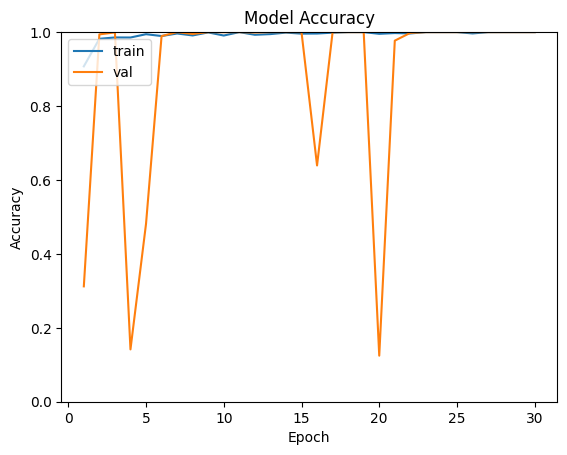

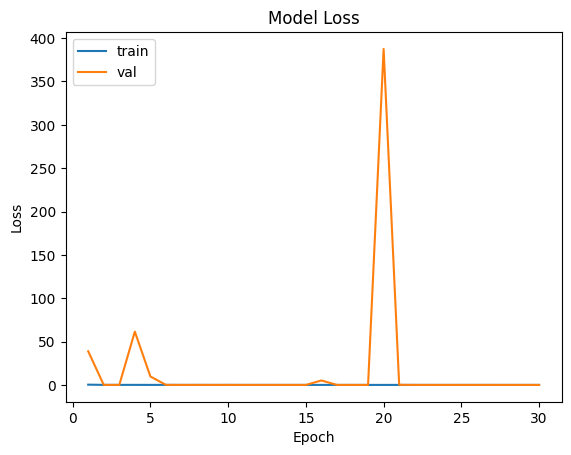

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 학습 곡선 그리기
num_epochs = len(history.history['accuracy'])
epoch_range = np.arange(1, num_epochs + 1)

plt.plot(epoch_range, history.history['accuracy'])
plt.plot(epoch_range, history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.ylim([0.0, 1.0])  # y축 범위를 0.0에서 1.0으로 설정
plt.show()

plt.plot(epoch_range, history.history['loss'])
plt.plot(epoch_range, history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 학습 곡선 그리기
num_epochs = len(history.history['accuracy'])
epoch_range = np.arange(1, num_epochs + 1)

plt.figure(figsize=(10, 5))
plt.plot(epoch_range, history.history['accuracy'])
plt.plot(epoch_range, history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(epoch_range, history.history['loss'])
plt.plot(epoch_range, history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(epoch_range, history.history['precision'])
plt.plot(epoch_range, history.history['val_precision'])
plt.title('Model Precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(epoch_range, history.history['recall'])
plt.plot(epoch_range, history.history['val_recall'])
plt.title('Model Recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# 구글 드라이브에 모델 저장
model.save('/content/drive/MyDrive/ResNet50_DEFG.h5')

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt

# 전체 테스트 데이터 세트 폴더 경로
test_dir = '/content/drive/MyDrive/data_DEFG_10Class_1080/test'

image_size = (224, 224)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=1,
    shuffle=False,
    class_mode='categorical')

# 저장된 모델 경로
model = load_model('/content/drive/MyDrive/ResNet50_DEFG.h5')

# 분류 및 평가
Y_pred = model.predict(test_generator, steps=len(test_generator))
y_pred = np.argmax(Y_pred, axis=1)

true_labels = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# 출력
print('테스트 결과')
print('---------------------')
for i, filename in enumerate(test_generator.filenames):
    print('{} : {}'.format(filename, class_labels[y_pred[i]]))

accuracy = accuracy_score(true_labels, y_pred)
precision = precision_score(true_labels, y_pred, average='macro')
recall = recall_score(true_labels, y_pred, average='macro')
f1score = f1_score(true_labels, y_pred, average='macro')

print('---------------------')
print('정확도 : {:.5f}'.format(accuracy))
print('정밀도 : {:.5f}'.format(precision))
print('재현율 : {:.5f}'.format(recall))
print('F1-score : {:.5f}'.format(f1score))

# Confusion Matrix and Classification Report
cm = confusion_matrix(true_labels, y_pred)
print('Confusion Matrix')
print(cm)

# 각 클래스별 정밀도, 재현율, F1-score, 그리고 지지도(support, 샘플 수)를 계산
cr = classification_report(true_labels, y_pred, target_names=class_labels)
print('Classification Report')
print(cr)

Found 2210 images belonging to 10 classes.
2210/2210 [==============================] - 1684s 762ms/step
테스트 결과
---------------------
back/back_left_D0.jpg : back
back/back_left_D10.jpg : back
back/back_left_D100.jpg : back
back/back_left_D108.jpg : back
back/back_left_D118.jpg : back
back/back_left_D140.jpg : back
back/back_left_D146.jpg : back
back/back_left_D151.jpg : back
back/back_left_D154.jpg : back
back/back_left_D17.jpg : back
back/back_left_D171.jpg : back
back/back_left_D18.jpg : back
back/back_left_D19.jpg : back
back/back_left_D191.jpg : back
back/back_left_D196.jpg : back
back/back_left_D2.jpg : back
back/back_left_D208.jpg : back
back/back_left_D217.jpg : back
back/back_left_D260.jpg : back
back/back_left_D275.jpg : back
back/back_left_D310.jpg : back
back/back_left_D319.jpg : back
back/back_left_D45.jpg : back
back/back_left_D46.jpg : back
back/back_left_D48.jpg : back
back/back_left_D5.jpg : back
back/back_left_D53.jpg : back
back/back_left_D62.jpg : back
back/back_lef

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt

# ABC 테스트 데이터 세트 폴더 경로
test_dir = '/content/drive/MyDrive/data_ABC_10Class_1080/test'

image_size = (224, 224)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=1,
    shuffle=False,
    class_mode='categorical')

# 저장된 모델 경로
model = load_model('/content/drive/MyDrive/ResNet50_DEFG.h5')

# 분류 및 평가
Y_pred = model.predict(test_generator, steps=len(test_generator))
y_pred = np.argmax(Y_pred, axis=1)

true_labels = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# 출력
print('테스트 결과')
print('---------------------')
for i, filename in enumerate(test_generator.filenames):
    print('{} : {}'.format(filename, class_labels[y_pred[i]]))

accuracy = accuracy_score(true_labels, y_pred)
precision = precision_score(true_labels, y_pred, average='macro')
recall = recall_score(true_labels, y_pred, average='macro')
f1score = f1_score(true_labels, y_pred, average='macro')

print('---------------------')
print('정확도 : {:.5f}'.format(accuracy))
print('정밀도 : {:.5f}'.format(precision))
print('재현율 : {:.5f}'.format(recall))
print('F1-score : {:.5f}'.format(f1score))

# Confusion Matrix and Classification Report
cm = confusion_matrix(true_labels, y_pred)
print('Confusion Matrix')
print(cm)

# 각 클래스별 정밀도, 재현율, F1-score, 그리고 지지도(support, 샘플 수)를 계산
cr = classification_report(true_labels, y_pred, target_names=class_labels)
print('Classification Report')
print(cr)

Found 2567 images belonging to 10 classes.
2567/2567 [==============================] - 2075s 808ms/step
테스트 결과
---------------------
back/back_left103.jpg : back_hurray
back/back_left1182.jpg : back_right
back/back_left1183.jpg : back
back/back_left1184.jpg : back
back/back_left1185.jpg : back_right
back/back_left1186.jpg : back
back/back_left1187.jpg : back_right
back/back_left1188.jpg : back_left
back/back_left1189.jpg : back_left
back/back_left1190.jpg : back_right
back/back_left1191.jpg : back_right
back/back_left1192.jpg : back_left
back/back_left1193.jpg : back
back/back_left1194.jpg : back
back/back_left1195.jpg : back
back/back_left1196.jpg : back
back/back_left1197.jpg : back_right
back/back_left1198.jpg : back
back/back_left1199.jpg : back_right
back/back_left120.jpg : back_hurray
back/back_left1200.jpg : back
back/back_left1201.jpg : back_left
back/back_left1202.jpg : back_right
back/back_left1203.jpg : back
back/back_left1204.jpg : back
back/back_left1205.jpg : back
back/b

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt

# A 테스트 데이터 세트 폴더 경로
test_dir = '/content/drive/MyDrive/data_A_10Class_1080/test'

image_size = (224, 224)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=1,
    shuffle=False,
    class_mode='categorical')

# 저장된 모델 경로
model = load_model('/content/drive/MyDrive/ResNet50_DEFG.h5')

# 분류 및 평가
Y_pred = model.predict(test_generator, steps=len(test_generator))
y_pred = np.argmax(Y_pred, axis=1)

true_labels = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# 출력
print('테스트 결과')
print('---------------------')
for i, filename in enumerate(test_generator.filenames):
    print('{} : {}'.format(filename, class_labels[y_pred[i]]))

accuracy = accuracy_score(true_labels, y_pred)
precision = precision_score(true_labels, y_pred, average='macro')
recall = recall_score(true_labels, y_pred, average='macro')
f1score = f1_score(true_labels, y_pred, average='macro')

print('---------------------')
print('정확도 : {:.5f}'.format(accuracy))
print('정밀도 : {:.5f}'.format(precision))
print('재현율 : {:.5f}'.format(recall))
print('F1-score : {:.5f}'.format(f1score))

# Confusion Matrix and Classification Report
cm = confusion_matrix(true_labels, y_pred)
print('Confusion Matrix')
print(cm)

# 각 클래스별 정밀도, 재현율, F1-score, 그리고 지지도(support, 샘플 수)를 계산
cr = classification_report(true_labels, y_pred, target_names=class_labels)
print('Classification Report')
print(cr)

Found 1252 images belonging to 10 classes.
1252/1252 [==============================] - 734s 586ms/step
테스트 결과
---------------------
back/back_left103.jpg : back_hurray
back/back_left120.jpg : back_hurray
back/back_left121.jpg : back_hurray
back/back_left122.jpg : back_hurray
back/back_left145.jpg : back_hurray
back/back_left158.jpg : back_hurray
back/back_left182.jpg : back_hurray
back/back_left184.jpg : back_hurray
back/back_left186.jpg : back_hurray
back/back_left191.jpg : back_hurray
back/back_left21.jpg : back_hurray
back/back_left214.jpg : back_hurray
back/back_left234.jpg : back_hurray
back/back_left236.jpg : back_hurray
back/back_left241.jpg : back_hurray
back/back_left250.jpg : back_hurray
back/back_left261.jpg : back_hurray
back/back_left283.jpg : back_hurray
back/back_left294.jpg : back_hurray
back/back_left296.jpg : back_hurray
back/back_left308.jpg : back_hurray
back/back_left31.jpg : back_hurray
back/back_left311.jpg : front_right_raised
back/back_left329.jpg : front
back

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:13

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt

# BC 테스트 데이터 세트 폴더 경로
test_dir = '/content/drive/MyDrive/data_BC_10Class_1080/test'

image_size = (224, 224)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=1,
    shuffle=False,
    class_mode='categorical')

# 저장된 모델 경로
model = load_model('/content/drive/MyDrive/ResNet50_DEFG.h5')

# 분류 및 평가
Y_pred = model.predict(test_generator, steps=len(test_generator))
y_pred = np.argmax(Y_pred, axis=1)

true_labels = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# 출력
print('테스트 결과')
print('---------------------')
for i, filename in enumerate(test_generator.filenames):
    print('{} : {}'.format(filename, class_labels[y_pred[i]]))

accuracy = accuracy_score(true_labels, y_pred)
precision = precision_score(true_labels, y_pred, average='macro')
recall = recall_score(true_labels, y_pred, average='macro')
f1score = f1_score(true_labels, y_pred, average='macro')

print('---------------------')
print('정확도 : {:.5f}'.format(accuracy))
print('정밀도 : {:.5f}'.format(precision))
print('재현율 : {:.5f}'.format(recall))
print('F1-score : {:.5f}'.format(f1score))

# Confusion Matrix and Classification Report
cm = confusion_matrix(true_labels, y_pred)
print('Confusion Matrix')
print(cm)

# 각 클래스별 정밀도, 재현율, F1-score, 그리고 지지도(support, 샘플 수)를 계산
cr = classification_report(true_labels, y_pred, target_names=class_labels)
print('Classification Report')
print(cr)

Found 1309 images belonging to 10 classes.
1309/1309 [==============================] - 1018s 778ms/step
테스트 결과
---------------------
back/back_left1182.jpg : back_right
back/back_left1183.jpg : back
back/back_left1184.jpg : back
back/back_left1185.jpg : back_right
back/back_left1186.jpg : back
back/back_left1187.jpg : back_right
back/back_left1188.jpg : back_left
back/back_left1189.jpg : back_left
back/back_left1190.jpg : back_right
back/back_left1191.jpg : back_right
back/back_left1192.jpg : back_left
back/back_left1193.jpg : back
back/back_left1194.jpg : back
back/back_left1195.jpg : back
back/back_left1196.jpg : back
back/back_left1197.jpg : back_right
back/back_left1198.jpg : back
back/back_left1199.jpg : back_right
back/back_left1200.jpg : back
back/back_left1201.jpg : back_left
back/back_left1202.jpg : back_right
back/back_left1203.jpg : back
back/back_left1204.jpg : back
back/back_left1205.jpg : back
back/back_left1206.jpg : back_right
back/back_left1207.jpg : back_right
back/b